# The Full, Running Example for RSS2021 / IROS2021

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video
from sklearn.model_selection import train_test_split

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface
from wombats.automaton import Automaton
from wombats.utils import get_experiment_paths

# setting all paths
EXPERIMENT_NAME = 'simple_running_example_rss'
ENV_ID1 = 'MiniGrid-MyDistShift-v0'
ENV_ID2 = 'MiniGrid-MyDistShiftOneWay-v0'
ENV_ID3 = 'MiniGrid-LavaComparison_SeshiaTwoGoals-v0'

ENV_ID = ENV_ID1

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
LEARNING_TEST_DATA_REL_FILEPATH = path_data['LEARNING_TEST_DATA_REL_FILEPATH']
GYM_MONITOR_LOG_DIR = path_data['GYM_MONITOR_LOG_DIR']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

In [3]:
path_data

{'EXPERIMENT_DIR': 'experiments/simple_running_example_rss',
 'PDFA_MODEL_CONFIG_FILE': 'wombats/config/PDFA_simple_running_example_rss.yaml',
 'DFA_MODEL_CONFIG_FILE': 'wombats/config/DFA_simple_running_example_rss.yaml',
 'TS_MODEL_CONFIG_FILE': 'wombats/config/TS_simple_running_example_rss.yaml',
 'GYM_MONITOR_LOG_DIR': 'experiments/simple_running_example_rss/minigrid_env_logs',
 'LEARNER_DATA_DIR': 'experiments/simple_running_example_rss/flexfringe_data',
 'LEARNING_TRAIN_DATA_REL_FILEPATH': 'flexfringe_data/simple_running_example_rss_train',
 'LEARNING_TEST_DATA_REL_FILEPATH': 'flexfringe_data/simple_running_example_rss_test',
 'ANALYSIS_DATA_DIR': 'experiments/simple_running_example_rss/analysis'}

## Loading in the Specification

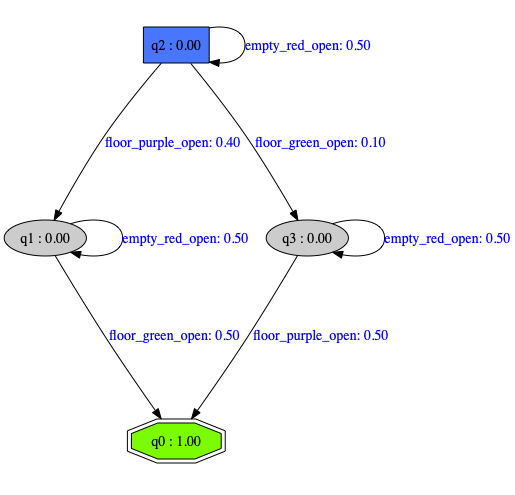

In [4]:
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)

pdfa_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'PDFA']))

# Sample from a PDFA

In [43]:
num_samples = 1000
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(
    num_samples, 
    N=max_trace_length)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    4.9s
[Parallel(

In [44]:
# Write learning data to files for inference
train_data_file = pdfa_specification.write_traces_to_file(
    traces,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)

In [45]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)

In [46]:
data = flexfringe.infer_model(training_file=train_data_file,
                              h='kldistance', #  --heuristic-name
                              d='kl_data',  # --data-name
                              m='2',  # --method
                              n='2',  # --runs
                              x='0',  # --extend
                              w='0',  # --shallowfirst
                              a='0',  # --largestblue
                              b='0',  # --blueblue
                              f='0',  # --finalred
                              I='0',  # --sinkson
                              t='1',  # --testmerge
                              q='0',  # --state_count
                              y='0',  # --symbol_count
#                               p='1.5')  # --extrapar num_samples=500
#                               p='0.8')  # --extrapar num_samples=300
#                               p='0.5')  # --extrapar num_samples=100
                              p='0.7')  # --extrapar
# flexfringe.draw_initial_model()
# flexfringe.draw_learned_model()

welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=0 -t=1 -q=0 -y=0 -p=0.7 --output-dir=experiments/simple_running_example_rss/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/simple_running_example_rss/flexfringe_data/simple_running_example_rss_train 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
blue: 3 , red: 1
m99957 blue: 2 , red: 1
No Merge was successful
x1578 blue: 3 , red: 2
m99965 blue: 2 , red: 2
No Merge was successful
x789 blue: 1 , red: 3
No Merge was successful
x422 blue: 2 , red: 4
m99940 blue: 1 , red: 4
No Merge was successful
x211 blue: 0 , red: 5


found intermediate solution with 5 and 5 red states
No valid solver specified, skipping...
dfasat running
blue: 0 , red: 1


found intermediate solution with 5 a

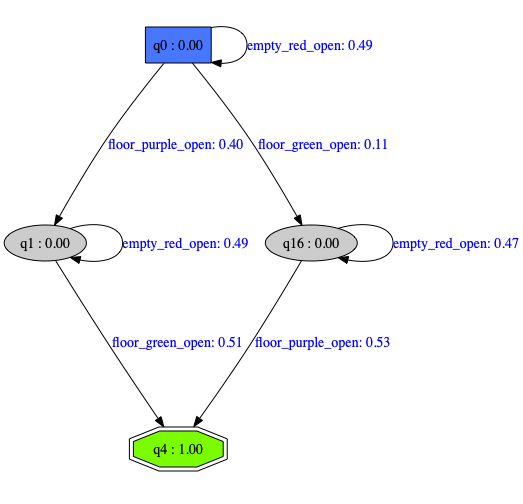

In [47]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   merge_sinks=True)
learned_pdfa.draw('_'.join([EXPERIMENT_NAME, 'learned', 'PDFA', 'FromTruePDFA']))

# Sample from a Product

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


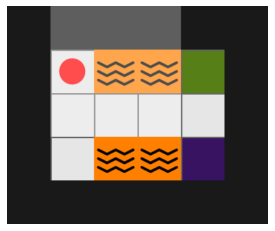

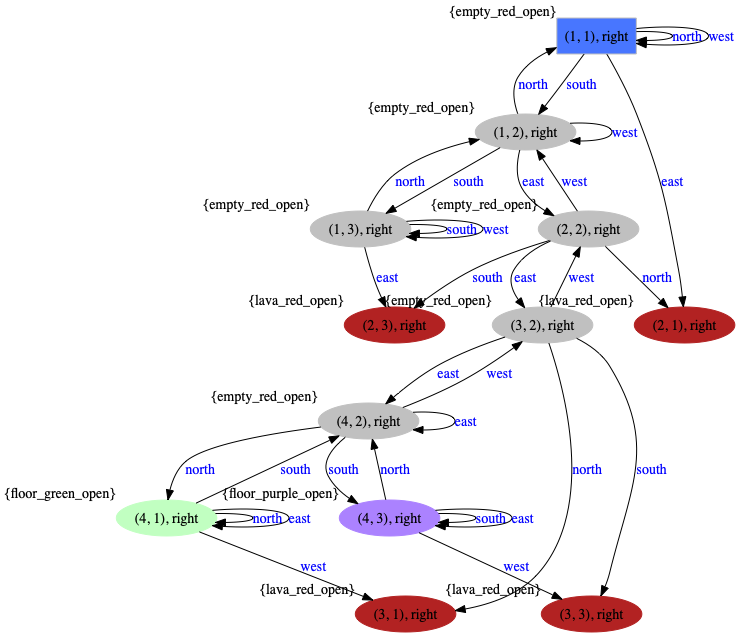

In [39]:
# env
def buildMinigridTS(env_id, draw=True):
    env = gym.make(env_id)
    env = StaticMinigridTSWrapper(env, actions_type='simple_static',
                                  monitor_log_location=GYM_MONITOR_LOG_DIR)
    env.reset()

    minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                      graph_data_format='minigrid')
    if draw:
        filename = os.path.join(GYM_MONITOR_LOG_DIR, env_id + '.png')
        env.render_notebook(filename)
        minigrid_TS.draw('_'.join([EXPERIMENT_NAME, env_id, 'TS']))
    
    return minigrid_TS

minigrid_TS = buildMinigridTS(ENV_ID)

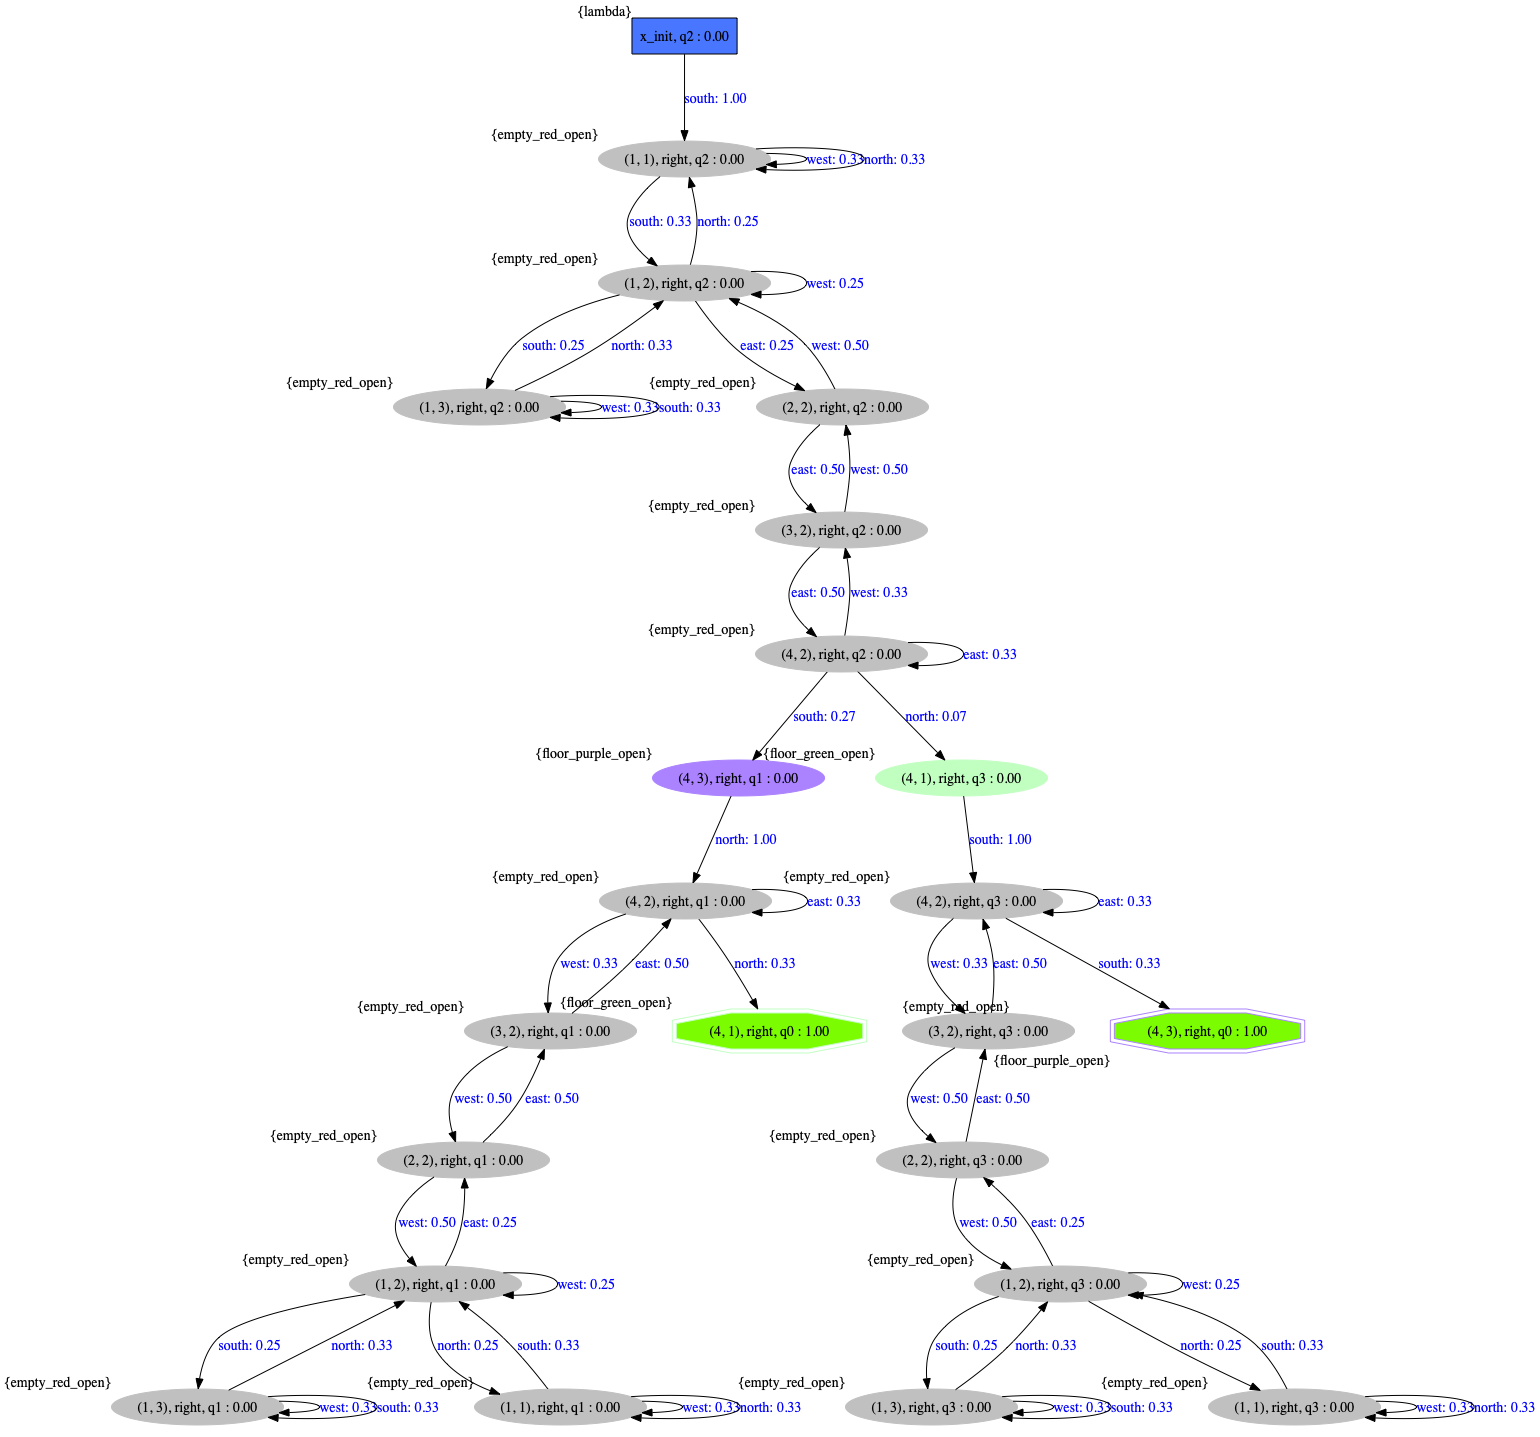

In [40]:
normalized_product = active_automata.get(automaton_type='Product',
                                         graph_data=(minigrid_TS,
                                                     pdfa_specification),
                                         normalize_trans_probabilities=True)
normalized_product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'model', 'norm',
                                  'product']))

In [41]:
def eval_sampled_traces(plans, record_video=False):
    if plans is None:
        return
    
    output_strings = []
    for controls, length, prob in zip(*plans):
        if controls is None:
            continue
        output_string, _, video_path = minigrid_TS.run(
            controls,
            record_video=record_video,
            overwrite_old_video=record_video)
        output_strings.append(output_string)
        
        if record_video:
            print(pdfa_specification.cross_entropy_approx(output_string))
            print(prob)
            print(length)
        
        if record_video:
            v = Video(video_path, embed=True,
                      html_attributes="controls muted autoplay loop")
            display(v)
        
    return output_strings

In [42]:
num_samples = 1000
max_trace_length = 20
plans = normalized_product.generate_traces(
    num_samples, 
    N=max_trace_length,
    max_resamples=40_000,
    complete_samples=False,
    force_MPS_sampler=False
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0715s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapse

KeyboardInterrupt: 

In [ ]:
obseervation_traces = eval_sampled_traces(plans)

# Write learning data to files for inference
train_data_file = pdfa_specification.write_traces_to_file(
    obseervation_traces,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)

In [ ]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)

In [ ]:
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_2.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_3.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_4.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_5.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_6.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_7.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_8.dot'))

In [ ]:
data = flexfringe.infer_model(training_file=train_data_file,
                              h='kldistance', #  --heuristic-name
                              d='kl_data',  # --data-name
                              m='2',  # --method
                              n='2',  # --runs
                              x='0',  # --extend
                              w='0',  # --shallowfirst
                              a='0',  # --largestblue
                              b='0',  # --blueblue
                              f='0',  # --finalred
                              I='0',  # --sinkson
                              t='1',  # --testmerge
                              q='0',  # --state_count
                              y='0',  # --symbol_count
#                               p='8.0')  # --extrapar
#                               p='8')  # --extrapar num_samples=750
                              p='10')  # --extrapar num_samples=750
# flexfringe.draw_initial_model()
# flexfringe.draw_learned_model()

In [ ]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
# learned_fdfa.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'FDFA']))

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   merge_sinks=True)
learned_pdfa.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'PDFA', 'FromTrueProduct']))

# Control Synthesis

In [48]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          learned_pdfa),
                             show_steps=False)

(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')

output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Optimal Controls: ['south', 'east', 'east', 'east', 'south', 'north', 'north']
Probability of Generated TS Observations in Spec: 0.002829389815481882
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_purple_open', 'empty_red_open', 'floor_green_open']
['(1, 1), right', '(1, 2), right', '(2, 2), right', '(3, 2), right', '(4, 2), right', '(4, 3), right', '(4, 2), right', '(4, 1), right']


In [49]:
# env
oneway_minigrid_TS = buildMinigridTS(ENV_ID2, draw=False)

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


In [50]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(oneway_minigrid_TS,
                                          learned_pdfa),
                             show_steps=False)

(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')

output_string, visited_states, video_path = oneway_minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Optimal Controls: ['south', 'east', 'east', 'east', 'south']
Probability of Generated TS Observations in Spec: 0.0031441743460671415
['empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open', 'empty_red_open', 'floor_purple_open']
['(1, 1), right', '(1, 2), right', '(2, 2), right', '(3, 2), right', '(4, 2), right', '(4, 3), right']


# Task Specification Learning on 2 Goals Environment (WITHOUT Safety Specification)

Given demonstrations $S$,

Learng task specification, where the task is to visit 2 goals. 
$$ Pr(\mathcal{A}_{est}) \approx Pr(L(\varphi)) $$

where task is a conjunction of 2 cosafe properties

$$ \varphi = \varphi_1 \land \varphi_2 $$

In [22]:
oneway_minigrid_TS = buildMinigridTS(ENV_ID3, draw=False)

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


In [23]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(oneway_minigrid_TS,
                                          learned_pdfa),
                             show_steps=False)

(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')

output_string, visited_states, video_path = oneway_minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Optimal Controls: ['north', 'north', 'north', 'east', 'east', 'east', 'east', 'east', 'north', 'west', 'south', 'west', 'west', 'west', 'west', 'west', 'north', 'west']
Probability of Generated TS Observations in Spec: 0.00018502243611241036
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_purple_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(3, 4), right', '(3, 3), right', '(3, 2), right', '(4, 2), right', '(5, 2), right', '(6, 2), right', '(7, 2), right', '(8, 2), right', '(8, 1), right', '(7, 1), right', '(7, 2), right', '(6, 2), right', '(5, 2), right', '(4, 2), right', '(3, 2), right', '(2, 2), right', '(2, 1), right', '(1, 1), right']
